In [1]:
# Initial notebook set up

%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

# These last two will make our charts look nice
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

# 1 d) Dynamic Adjustment in OLG Models

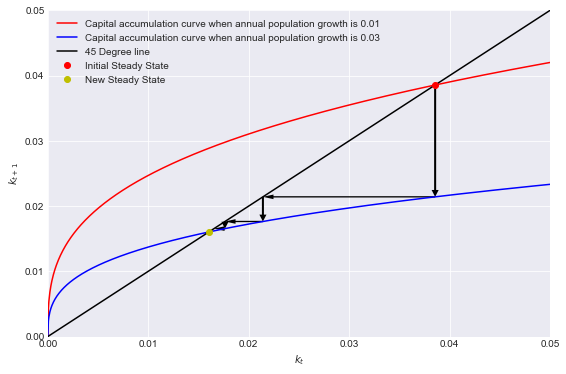

In [2]:
def Transition(Epsilon, DiscFac, PopGrowth0, PopGrowth1, YearsPerGeneration, kMax):
    '''Inputs:
        Epsilon: Elasticity of output with respect to capital/labour ratio
        DiscFac: One period discount factor
        YearPerGeneration: No. of years per generation
        PopGrowth: Gross growth rate of population in one period'''
    
    # Define some parameters
    Beta = DiscFac**YearsPerGeneration
    xi0 = PopGrowth0**YearsPerGeneration
    xi1 = PopGrowth1**YearsPerGeneration
    Q0 = (1-Epsilon)*(Beta/(1+Beta))/xi0
    Q1 = (1-Epsilon)*(Beta/(1+Beta))/xi1
    kBar0 = Q0**(1/(1-Epsilon))
    kBar1 = Q1**(1/(1-Epsilon))
    
    # Plot the OLG capital accumulation curve for both scenarios
    plt.figure(figsize=(9,6))
    kt_range = np.linspace(0, kMax, 1000)
    
    ktp0 = Q0*kt_range**Epsilon
    ktp1 = Q1*kt_range**Epsilon
    plt.plot(kt_range, ktp0, 'r-', label='Capital accumulation curve when annual population growth is 0.01')
    plt.plot(kt_range, ktp1, 'b-', label='Capital accumulation curve when annual population growth is 0.03')
    plt.plot(kt_range, kt_range, 'k-', label='45 Degree line')
    
    # Plot the transition path from steady state 0 to steady state 1
    kt_ar = kBar0
    ktp1_ar = kBar0
    for i in range(3):
        plt.arrow(kt_ar, ktp1_ar, 0., Q1*kt_ar**Epsilon-kt_ar,
                  length_includes_head=True,
                  lw=0.01,
                  width=0.0002,
                  head_width=0.0007,
                  color='black',
                  edgecolor=None)
        plt.arrow(kt_ar, Q1*kt_ar**Epsilon, Q1*kt_ar**Epsilon-kt_ar, 0.,
                  length_includes_head=True,
                  lw=0.01,
                  width=0.0002,
                  head_width=0.0007,
                  color='black',
                  edgecolor=None)
        
        kt_ar = Q1*kt_ar**Epsilon
        ktp1_ar = kt_ar
        i = i+1  
        
    # Plot kbar
    plt.plot(kBar0, kBar0, 'ro', label='Initial Steady State')
    plt.plot(kBar1, kBar1, 'yo', label='New Steady State')

    
    plt.legend()
    plt.xlim(0 ,kMax)
    plt.ylim(0, kMax)
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.show()
    return None

Transition(0.33,0.96,1.01,1.03,30,0.05)


# Perfect Foresight Model Impatience Conditions

After using the Jupyter notebook [Gentle-Intro-To-HARK-PerfForesightCRRA](https://github.com/econ-ark/DemARK/blob/Course-Choice/notebooks/Gentle-Intro-To-HARK-PerfForesightCRRA.ipynb) to learn the basics of HARK, answer the following questions:



[PerfectForesightCRRA](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Consumption/PerfForesightCRRA) defines several 'impatience' conditions that are useful in understanding the model.  We will use here the HARK toolkit's solution to the permanent-income-normalized version of the model, constructing a consumption function for the ratio of consumption to permanent income.

The handout claims that in order for the perfect foresight consumption model to be useful, it is necessary to impose
the 'return impatience condition' (RIC):

\begin{eqnarray}
  \frac{(R \beta)^{1/\rho}}{R} & < & 1
\end{eqnarray}

and defines some other inequalities that help characterize what happens in the model (or whether it has a solution at all).

This question asks you to explore numerically what happens to the consumption function as these conditions get close to failing.

Specifically, given the default set of parameter values used in the notebook below, you should:

1. Plot the consumption function for a perfect foresight consumer with those defaultparameter values, along with the "sustainable" level of consumption that would preserve wealth
1. Calculate the numerical values of the three impatience conditions
0. Calculate the values of $\beta$ and $G$ such that the impatience factors on the LHS of the two equations would be exactly equal to 1

Next, along with the sustainable consumption function, you should plot a sequence of consumption functions of a HARK `PerfForesightConsumerType` consumer, for a set of parameter values that go from the default value toward some interesting point:

1. For some sequence of values of $\beta$ that go from the default value to some value very close to the point where the RIC fails
   * Actually, we do this one for you to show how to do it generically
0. For some sequence of values of $G$ that go from the default value to some value just below the maximum possible value of $G$.  (Why is it the maximum possible value?)
0. For some sequence of values of $\rho$ that go from the default value to some value that is very large

and in each case you should explain, using analytical mathematical reasoning, the numerical result you get.  (You can just type your answers in the notebook).

In [3]:
# Import the machinery for solving the perfect foresight model and the default parameters

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType # Import the consumer type
import HARK.ConsumptionSaving.ConsumerParameters as Params # Import default parameters

# Now extract the default values of the parameters of interest

CRRA       = Params.CRRA 
Rfree      = Params.Rfree 
DiscFac    = Params.DiscFac
PermGroFac = Params.PermGroFac
rfree      = Rfree-1



In [4]:
# Now create a perfect foresight consumer example
PFagent = PerfForesightConsumerType(**Params.init_perfect_foresight)
PFagent.cycles = 0 # We need the consumer to be infinitely lived
PFagent.LivPrb = [1.0] # Suppress the possibility of dying

# Solve the agent's problem
PFagent.solve()


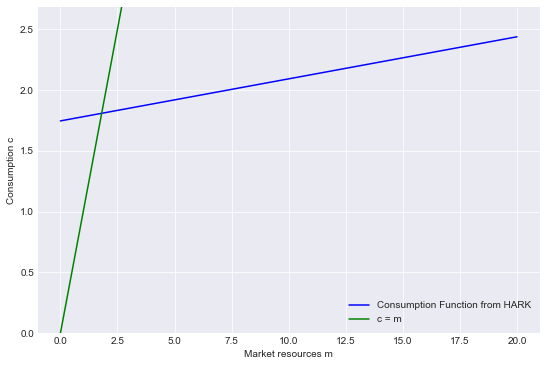

In [5]:
# Plot the consumption function 

# Remember, after invoking .solve(), the consumption function is stored as PFagent.solution[0].cFunc

# Set out some range of market resources that we want to plot consumption for

mMin = 0
mMax = 20
numPoints = 100
m_range  = np.linspace(mMin, mMax, numPoints) # This creates an array of points in the given range

# Feed our range of market resources into our consumption function in order to get consumption at each point

cHARK = PFagent.solution[0].cFunc(m_range) # Because the input m_range is an array, the output cHARK is too

# Construct the 45 degree line where value on vertical axis matches horizontal
degree45 = m_range # This will be the array of y points identical to the x points

# Find the value of consumption at the largest value of m
c_max    = PFagent.solution[0].cFunc([mMax])

# Use matplotlib package (imported in first cell) to plot the consumption function
plt.figure(figsize=(9,6)) # set the figure size
plt.ylim(0.,c_max[0]*1.1)     # set the range for the vertical axis with a 10 percent margin at top
plt.plot(m_range, cHARK, 'b', label='Consumption Function from HARK') # Plot m's on the x axis, versus our c on the y axis, and make the line blue, with a label
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c')      # y axis label

# The plot is named plt and it hangs around like a variable 
# but is not displayed until you do a plt.show()

plt.plot(m_range, degree45  , 'g', label='c = m') # Add 45 degree line
plt.legend() # construct the legend

plt.show() # show the plot

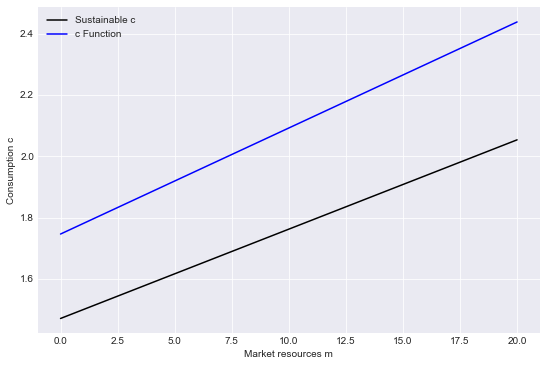

In [6]:
# QUESTION: Now calculate and plot the "sustainable" level of consumption that leaves wealth untouched
# and plot it against the perfect foresight solution

cSustainable = (rfree/Rfree)*(m_range-1+1/(1-PermGroFac[0]/Rfree)) # For any given level of m, the level of c that would leave wealth unchanged
# Obviously, 0 is the wrong formula here -- you should fill in the right one

plt.figure(figsize=(9,6)) # set the figure size
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c') # y axis label

plt.plot(m_range, cSustainable  , 'k', label='Sustainable c') # Add sustainable c line
plt.plot(m_range, cHARK, 'b', label='c Function')
plt.legend()

plt.show() # show the plot

In [7]:
# Compute the values of the impatience conditions under default parameter values

Pat_df  = Rfree*DiscFac # Plug in the formula for the absolute patience factor
PatR_df = (Rfree*DiscFac)**(1/CRRA)/Rfree # Plug in the formula for the return patience factor
PatG_df = (Rfree*DiscFac)**(1/CRRA)/PermGroFac[0] # Plug in the formula for the growth patience factor

DiscFac_lim = Rfree**(CRRA-1) # The limiting value such that the RIC exactly fails
PermGroFac_lim = (Rfree*DiscFac)**(1/CRRA) # The limiting value such that the GIC exactly fails
print('The absolute patience factor is ', Pat_df)
print('The return patience factor is ', PatR_df)
print('The growth patience factor is ', PatG_df)
print('The limiting value of discount factor that the RIC exactly fails is ', DiscFac_lim)
print('The limiting value of permanent income growth rate that the GIC exactly fails is ', PermGroFac_lim)


The absolute patience factor is  0.9888
The return patience factor is  0.9654215840509556
The growth patience factor is  0.9845388431410735
The limiting value of discount factor that the RIC exactly fails is  1.03
The limiting value of permanent income growth rate that the GIC exactly fails is  0.9943842315724842


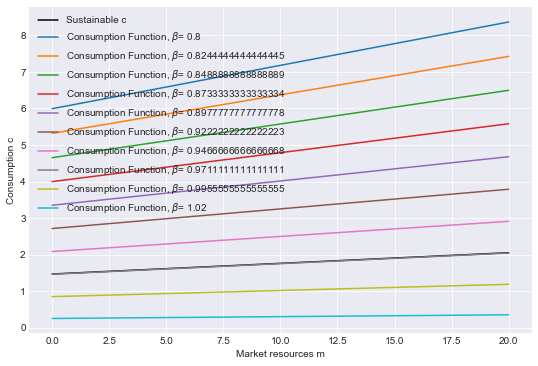

In [8]:
# The code below is an example to show you how to plot a set of consumption functions
# for a sequence of values of the discount factor.  You should be
# to adapt this code to solve the rest of the sproblem posed above

howClose=0.01 # How close to come to the limit where the impatience condition fails
DiscFac_min = 0.8
DiscFac_max = DiscFac_lim-howClose # 
numPoints = 10
DiscFac_list = np.linspace(DiscFac_min, DiscFac_max, numPoints) # Create a list of beta values

plt.figure(figsize=((9,6))) # set the plot size

plt.plot(m_range, cSustainable, 'k', label='Sustainable c') # Add sustainable c line
for i in range(len(DiscFac_list)):
    PFagent.DiscFac = DiscFac_list[i]
    PFagent.solve()
    cHARK = PFagent.solution[0].cFunc(m_range)
    plt.plot(m_range, cHARK, label='Consumption Function, $\\beta$= '+str(PFagent.DiscFac))

PFagent.DiscFac = Params.DiscFac # return discount factor to default value
PFagent.solve() # It's nice to leave the PFagent back with its default solution
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c')      # y axis label
plt.legend()                     # show legend
plt.show()                       # plot chart


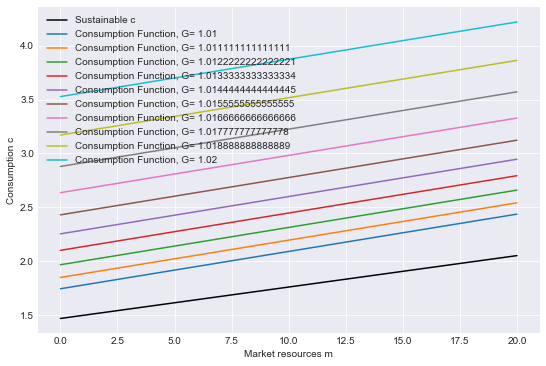

In [9]:
# Now plot the consumption functions for alternate values of G as described above
# Note the tricky fact that PermGroFac is a list of values because it could 
# be representing some arbitrary sequence of growth rates
# QUESTION: What is the upper bound for possible values of G?  Why?

PermGro_min = PermGroFac[0]
PermGro_max = Rfree-howClose # Arbitrary number larger than the default value
PermGroArray = np.linspace(PermGro_min, PermGro_max, numPoints, endpoint=True)
PermGroList = PermGroArray.tolist() # Make growth factors a list

plt.figure(figsize=((9,6))) # set the plot size

plt.plot(m_range, cSustainable, 'k', label='Sustainable c') # Add sustainable c line
for i in range(len(PermGroList)):
    PFagent.PermGroFac[0] = PermGroList[i]
    PFagent.solve()
    cHARK = PFagent.solution[0].cFunc(m_range)
    plt.plot(m_range, cHARK, label='Consumption Function, G= '+str(PFagent.PermGroFac[0]))
       
PFagent.PermGroFac[0] = Params.PermGroFac[0] # return discount factor to default value
PFagent.solve() # It's nice to leave the PFagent back with its default solution
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c')      # y axis label
plt.legend()                     # show legend
plt.show()                       # plot chart


From the Finite Human Wealth Condition, we derive the upper bound for the growth rate of permanent income, which is the interest rate. If G is greater than the interest rate, the human wealth will diverge to infinite, the problem will not be well-defined. Within the upper bound, as G increases, the human wealth will also increae, so the consumption.

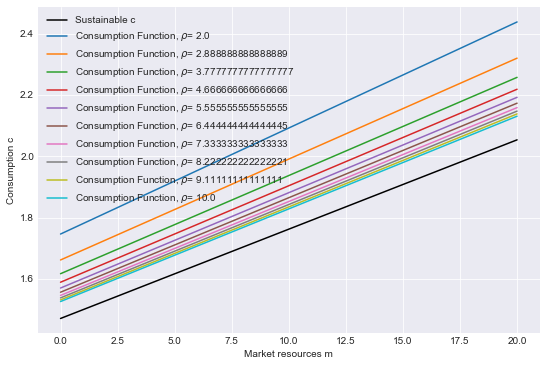

In [26]:
# Now plot the consumption functions for values of rho above the default value

CRRA_min = CRRA
CRRA_max = 10
numPoints = 10
CRRA_list = np.linspace(CRRA_min, CRRA_max, numPoints) # Create a list of beta values

plt.figure(figsize=((9,6))) # set the plot size

plt.plot(m_range, cSustainable, 'k', label='Sustainable c') # Add sustainable c line
for i in range(len(CRRA_list)):
    PFagent.CRRA = CRRA_list[i]
    PFagent.solve()
    cHARK = PFagent.solution[0].cFunc(m_range)
    plt.plot(m_range, cHARK, label='Consumption Function, $\\rho$= '+str(PFagent.CRRA))

PFagent.CRRA = Params.CRRA # return discount factor to default value
PFagent.solve() # It's nice to leave the PFagent back with its default solution
plt.xlabel('Market resources m') # x axis label
plt.ylabel('Consumption c')      # y axis label
plt.legend()                     # show legend
plt.show()                       # plot chart
